Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [1]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
JPEGIMAGES_FOLDER_PATH = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/JPEGImages/"
path_project = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/"

In [3]:
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)
print(labels_dirs)
len(labels_dirs) # 50 labels / subdirectories

['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


50

In [4]:
def get_num_label(label):
    return labels_dirs.index(labels_dirs)

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [5]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()

In [6]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH) : 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """

    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Deleted existent annotations.csv file.
 ---------------------------
Sucessfully created annotations.csv file.


In [7]:
class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
dataset = AWA2Dataset()

## TODO : Change transforms. Currently this is not useful.
dataset.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    transforms.CenterCrop((224,224)),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the reaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

# Testing. All good
random_index = np.random.randint(0, len(dataset))
image, label = dataset[random_index]

In [9]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=4, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 


###   AlexNet  ###

In [10]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

Using cache found in C:\Users\1/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### CUDA ###

In [11]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [12]:
torch.cuda.is_available()

True

### Question: nombre de noeud ###

In [13]:
nb_noeud = 4096

In [14]:
AlexNet_model.classifier[4] = torch.nn.Linear(4096,nb_noeud)
AlexNet_model.classifier[6] = torch.nn.Linear(nb_noeud,50)

In [15]:
import sys
print(sys.version)

3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]


In [16]:
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Question: check dimension de dataloader   ###

###  Split training data and test data ###

In [17]:
batch_size = 32

In [18]:
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

In [19]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])

In [20]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

###   transfomer labels  ###

In [21]:
path_class = path_project +"classes.txt"
class_animal = pd.read_table(path_class,header= None)

In [22]:
animals = class_animal[1]

In [23]:
dict_label_animal = {}

In [24]:
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1

In [25]:
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels)   

###   Loss function  ###

In [26]:
lr = 0.001

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_model.parameters(), lr= lr , momentum=0.9)

###  Training  ###

In [28]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss ))
        running_loss = 0.0

print('Finished Training of AlexNet')

[1,     1] loss: 3.924
[1,     2] loss: 3.880
[1,     3] loss: 3.908
[1,     4] loss: 3.782
[1,     5] loss: 3.975
[1,     6] loss: 3.808
[1,     7] loss: 3.744
[1,     8] loss: 3.464
[1,     9] loss: 3.701
[1,    10] loss: 3.614
[1,    11] loss: 3.664
[1,    12] loss: 3.401
[1,    13] loss: 3.620
[1,    14] loss: 3.494
[1,    15] loss: 3.643
[1,    16] loss: 2.935
[1,    17] loss: 3.294
[1,    18] loss: 3.438
[1,    19] loss: 3.352
[1,    20] loss: 3.082
[1,    21] loss: 2.867
[1,    22] loss: 2.639
[1,    23] loss: 3.487
[1,    24] loss: 3.060
[1,    25] loss: 2.594
[1,    26] loss: 2.640
[1,    27] loss: 2.654
[1,    28] loss: 2.377
[1,    29] loss: 2.721
[1,    30] loss: 2.252
[1,    31] loss: 2.236
[1,    32] loss: 2.322
[1,    33] loss: 2.648
[1,    34] loss: 1.830
[1,    35] loss: 1.865
[1,    36] loss: 2.431
[1,    37] loss: 2.648
[1,    38] loss: 1.369
[1,    39] loss: 1.556
[1,    40] loss: 2.685
[1,    41] loss: 2.566
[1,    42] loss: 1.708
[1,    43] loss: 1.312
[1,    44] 

[1,   358] loss: 1.046
[1,   359] loss: 1.034
[1,   360] loss: 1.151
[1,   361] loss: 0.983
[1,   362] loss: 0.662
[1,   363] loss: 1.147
[1,   364] loss: 1.363
[1,   365] loss: 1.229
[1,   366] loss: 1.074
[1,   367] loss: 1.712
[1,   368] loss: 1.010
[1,   369] loss: 1.039
[1,   370] loss: 0.939
[1,   371] loss: 0.967
[1,   372] loss: 0.902
[1,   373] loss: 1.321
[1,   374] loss: 0.931
[1,   375] loss: 0.791
[1,   376] loss: 1.041
[1,   377] loss: 1.183
[1,   378] loss: 0.842
[1,   379] loss: 0.702
[1,   380] loss: 0.973
[1,   381] loss: 1.158
[1,   382] loss: 1.100
[1,   383] loss: 0.691
[1,   384] loss: 1.128
[1,   385] loss: 0.665
[1,   386] loss: 1.110
[1,   387] loss: 0.814
[1,   388] loss: 1.108
[1,   389] loss: 1.291
[1,   390] loss: 1.507
[1,   391] loss: 1.102
[1,   392] loss: 1.135
[1,   393] loss: 1.105
[1,   394] loss: 1.324
[1,   395] loss: 1.240
[1,   396] loss: 0.860
[1,   397] loss: 0.758
[1,   398] loss: 1.516
[1,   399] loss: 1.404
[1,   400] loss: 1.215
[1,   401] 

[1,   715] loss: 1.198
[1,   716] loss: 1.208
[1,   717] loss: 1.075
[1,   718] loss: 0.724
[1,   719] loss: 1.130
[1,   720] loss: 0.535
[1,   721] loss: 0.417
[1,   722] loss: 0.819
[1,   723] loss: 1.029
[1,   724] loss: 0.927
[1,   725] loss: 0.637
[1,   726] loss: 1.037
[1,   727] loss: 0.851
[1,   728] loss: 1.112
[1,   729] loss: 0.741
[1,   730] loss: 0.872
[1,   731] loss: 1.005
[1,   732] loss: 0.976
[1,   733] loss: 0.849
[1,   734] loss: 1.017
[1,   735] loss: 1.013
[1,   736] loss: 0.962
[1,   737] loss: 1.292
[1,   738] loss: 1.372
[1,   739] loss: 0.750
[1,   740] loss: 0.896
[1,   741] loss: 0.707
[1,   742] loss: 0.832
[1,   743] loss: 0.564
[1,   744] loss: 0.767
[1,   745] loss: 0.764
[1,   746] loss: 1.363
[1,   747] loss: 1.355
[1,   748] loss: 1.336
[1,   749] loss: 0.808
[1,   750] loss: 0.747
[1,   751] loss: 0.974
[1,   752] loss: 1.088
[1,   753] loss: 1.015
[1,   754] loss: 0.909
[1,   755] loss: 0.854
[1,   756] loss: 0.836
[1,   757] loss: 1.272
[1,   758] 

[2,   139] loss: 0.670
[2,   140] loss: 0.581
[2,   141] loss: 0.640
[2,   142] loss: 0.941
[2,   143] loss: 0.477
[2,   144] loss: 0.792
[2,   145] loss: 0.904
[2,   146] loss: 0.890
[2,   147] loss: 0.612
[2,   148] loss: 0.672
[2,   149] loss: 0.614
[2,   150] loss: 0.348
[2,   151] loss: 0.374
[2,   152] loss: 0.909
[2,   153] loss: 0.409
[2,   154] loss: 1.017
[2,   155] loss: 0.846
[2,   156] loss: 0.221
[2,   157] loss: 0.739
[2,   158] loss: 0.794
[2,   159] loss: 0.647
[2,   160] loss: 0.686
[2,   161] loss: 0.669
[2,   162] loss: 0.899
[2,   163] loss: 0.792
[2,   164] loss: 0.768
[2,   165] loss: 0.464
[2,   166] loss: 0.732
[2,   167] loss: 0.384
[2,   168] loss: 0.366
[2,   169] loss: 0.412
[2,   170] loss: 0.877
[2,   171] loss: 0.690
[2,   172] loss: 0.331
[2,   173] loss: 0.364
[2,   174] loss: 1.144
[2,   175] loss: 0.545
[2,   176] loss: 0.511
[2,   177] loss: 0.383
[2,   178] loss: 0.476
[2,   179] loss: 0.181
[2,   180] loss: 0.339
[2,   181] loss: 0.749
[2,   182] 

[2,   496] loss: 0.717
[2,   497] loss: 0.653
[2,   498] loss: 1.067
[2,   499] loss: 0.390
[2,   500] loss: 0.609
[2,   501] loss: 0.615
[2,   502] loss: 0.976
[2,   503] loss: 0.344
[2,   504] loss: 0.139
[2,   505] loss: 0.637
[2,   506] loss: 0.391
[2,   507] loss: 0.505
[2,   508] loss: 0.625
[2,   509] loss: 0.487
[2,   510] loss: 0.564
[2,   511] loss: 0.580
[2,   512] loss: 0.955
[2,   513] loss: 0.410
[2,   514] loss: 0.627
[2,   515] loss: 0.460
[2,   516] loss: 0.623
[2,   517] loss: 0.359
[2,   518] loss: 0.250
[2,   519] loss: 0.535
[2,   520] loss: 0.767
[2,   521] loss: 0.593
[2,   522] loss: 0.448
[2,   523] loss: 0.675
[2,   524] loss: 0.591
[2,   525] loss: 0.745
[2,   526] loss: 0.398
[2,   527] loss: 0.442
[2,   528] loss: 1.062
[2,   529] loss: 0.479
[2,   530] loss: 0.223
[2,   531] loss: 0.523
[2,   532] loss: 0.690
[2,   533] loss: 0.736
[2,   534] loss: 0.744
[2,   535] loss: 0.687
[2,   536] loss: 0.812
[2,   537] loss: 0.371
[2,   538] loss: 0.540
[2,   539] 

[2,   853] loss: 0.308
[2,   854] loss: 0.293
[2,   855] loss: 0.577
[2,   856] loss: 0.477
[2,   857] loss: 0.416
[2,   858] loss: 0.471
[2,   859] loss: 0.888
[2,   860] loss: 0.482
[2,   861] loss: 0.724
[2,   862] loss: 0.545
[2,   863] loss: 0.599
[2,   864] loss: 0.803
[2,   865] loss: 0.608
[2,   866] loss: 0.324
[2,   867] loss: 0.806
[2,   868] loss: 0.569
[2,   869] loss: 0.201
[2,   870] loss: 0.763
[2,   871] loss: 0.403
[2,   872] loss: 0.723
[2,   873] loss: 0.514
[2,   874] loss: 0.567
[2,   875] loss: 0.546
[2,   876] loss: 0.645
[2,   877] loss: 0.676
[2,   878] loss: 0.336
[2,   879] loss: 0.873
[2,   880] loss: 0.528
[2,   881] loss: 0.734
[2,   882] loss: 0.421
[2,   883] loss: 0.429
[2,   884] loss: 0.504
[2,   885] loss: 0.538
[2,   886] loss: 0.878
[2,   887] loss: 0.426
[2,   888] loss: 0.473
[2,   889] loss: 0.419
[2,   890] loss: 0.497
[2,   891] loss: 0.571
[2,   892] loss: 0.410
[2,   893] loss: 0.929
[2,   894] loss: 0.531
[2,   895] loss: 0.457
[2,   896] 

[3,   277] loss: 0.430
[3,   278] loss: 0.359
[3,   279] loss: 0.290
[3,   280] loss: 0.427
[3,   281] loss: 0.307
[3,   282] loss: 0.293
[3,   283] loss: 0.450
[3,   284] loss: 0.509
[3,   285] loss: 0.415
[3,   286] loss: 0.296
[3,   287] loss: 0.414
[3,   288] loss: 0.246
[3,   289] loss: 0.773
[3,   290] loss: 0.467
[3,   291] loss: 0.294
[3,   292] loss: 0.408
[3,   293] loss: 0.365
[3,   294] loss: 0.546
[3,   295] loss: 0.285
[3,   296] loss: 0.601
[3,   297] loss: 0.651
[3,   298] loss: 0.403
[3,   299] loss: 0.133
[3,   300] loss: 0.193
[3,   301] loss: 0.658
[3,   302] loss: 0.262
[3,   303] loss: 0.433
[3,   304] loss: 0.385
[3,   305] loss: 0.240
[3,   306] loss: 0.152
[3,   307] loss: 0.180
[3,   308] loss: 0.135
[3,   309] loss: 0.543
[3,   310] loss: 0.264
[3,   311] loss: 0.164
[3,   312] loss: 0.643
[3,   313] loss: 0.406
[3,   314] loss: 0.612
[3,   315] loss: 0.367
[3,   316] loss: 0.386
[3,   317] loss: 0.197
[3,   318] loss: 0.471
[3,   319] loss: 0.238
[3,   320] 

[3,   634] loss: 0.187
[3,   635] loss: 0.423
[3,   636] loss: 0.188
[3,   637] loss: 0.533
[3,   638] loss: 0.205
[3,   639] loss: 0.341
[3,   640] loss: 0.128
[3,   641] loss: 0.176
[3,   642] loss: 0.305
[3,   643] loss: 0.206
[3,   644] loss: 0.445
[3,   645] loss: 0.328
[3,   646] loss: 0.235
[3,   647] loss: 0.392
[3,   648] loss: 0.239
[3,   649] loss: 0.342
[3,   650] loss: 0.428
[3,   651] loss: 0.310
[3,   652] loss: 0.288
[3,   653] loss: 0.603
[3,   654] loss: 0.267
[3,   655] loss: 0.366
[3,   656] loss: 0.409
[3,   657] loss: 0.368
[3,   658] loss: 0.241
[3,   659] loss: 0.299
[3,   660] loss: 0.175
[3,   661] loss: 0.157
[3,   662] loss: 0.257
[3,   663] loss: 0.086
[3,   664] loss: 0.193
[3,   665] loss: 0.216
[3,   666] loss: 0.276
[3,   667] loss: 0.164
[3,   668] loss: 0.347
[3,   669] loss: 0.564
[3,   670] loss: 0.496
[3,   671] loss: 0.244
[3,   672] loss: 0.390
[3,   673] loss: 0.232
[3,   674] loss: 0.301
[3,   675] loss: 0.154
[3,   676] loss: 0.320
[3,   677] 

[4,    58] loss: 0.322
[4,    59] loss: 0.366
[4,    60] loss: 0.299
[4,    61] loss: 0.521
[4,    62] loss: 0.217
[4,    63] loss: 0.137
[4,    64] loss: 0.328
[4,    65] loss: 0.264
[4,    66] loss: 0.453
[4,    67] loss: 0.163
[4,    68] loss: 0.210
[4,    69] loss: 0.241
[4,    70] loss: 0.306
[4,    71] loss: 0.212
[4,    72] loss: 0.194
[4,    73] loss: 0.479
[4,    74] loss: 0.670
[4,    75] loss: 0.204
[4,    76] loss: 0.289
[4,    77] loss: 0.297
[4,    78] loss: 0.553
[4,    79] loss: 0.294
[4,    80] loss: 0.293
[4,    81] loss: 0.054
[4,    82] loss: 0.247
[4,    83] loss: 0.143
[4,    84] loss: 0.231
[4,    85] loss: 0.315
[4,    86] loss: 0.371
[4,    87] loss: 0.288
[4,    88] loss: 0.412
[4,    89] loss: 0.178
[4,    90] loss: 0.391
[4,    91] loss: 0.159
[4,    92] loss: 0.319
[4,    93] loss: 0.341
[4,    94] loss: 0.084
[4,    95] loss: 0.177
[4,    96] loss: 0.267
[4,    97] loss: 0.281
[4,    98] loss: 0.425
[4,    99] loss: 0.131
[4,   100] loss: 0.339
[4,   101] 

[4,   415] loss: 0.154
[4,   416] loss: 0.277
[4,   417] loss: 0.269
[4,   418] loss: 0.163
[4,   419] loss: 0.294
[4,   420] loss: 0.194
[4,   421] loss: 0.423
[4,   422] loss: 0.158
[4,   423] loss: 0.136
[4,   424] loss: 0.280
[4,   425] loss: 0.098
[4,   426] loss: 0.134
[4,   427] loss: 0.112
[4,   428] loss: 0.507
[4,   429] loss: 0.321
[4,   430] loss: 0.308
[4,   431] loss: 0.168
[4,   432] loss: 0.072
[4,   433] loss: 0.217
[4,   434] loss: 0.289
[4,   435] loss: 0.145
[4,   436] loss: 0.188
[4,   437] loss: 0.355
[4,   438] loss: 0.232
[4,   439] loss: 0.276
[4,   440] loss: 0.173
[4,   441] loss: 0.190
[4,   442] loss: 0.077
[4,   443] loss: 0.135
[4,   444] loss: 0.425
[4,   445] loss: 0.231
[4,   446] loss: 0.263
[4,   447] loss: 0.259
[4,   448] loss: 0.270
[4,   449] loss: 0.128
[4,   450] loss: 0.170
[4,   451] loss: 0.201
[4,   452] loss: 0.295
[4,   453] loss: 0.276
[4,   454] loss: 0.069
[4,   455] loss: 0.201
[4,   456] loss: 0.134
[4,   457] loss: 0.157
[4,   458] 

[4,   772] loss: 0.187
[4,   773] loss: 0.357
[4,   774] loss: 0.345
[4,   775] loss: 0.103
[4,   776] loss: 0.098
[4,   777] loss: 0.441
[4,   778] loss: 0.377
[4,   779] loss: 0.159
[4,   780] loss: 0.268
[4,   781] loss: 0.149
[4,   782] loss: 0.217
[4,   783] loss: 0.149
[4,   784] loss: 0.181
[4,   785] loss: 0.099
[4,   786] loss: 0.248
[4,   787] loss: 0.176
[4,   788] loss: 0.281
[4,   789] loss: 0.252
[4,   790] loss: 0.215
[4,   791] loss: 0.185
[4,   792] loss: 0.463
[4,   793] loss: 0.071
[4,   794] loss: 0.082
[4,   795] loss: 0.097
[4,   796] loss: 0.192
[4,   797] loss: 0.181
[4,   798] loss: 0.162
[4,   799] loss: 0.370
[4,   800] loss: 0.364
[4,   801] loss: 0.074
[4,   802] loss: 0.168
[4,   803] loss: 0.102
[4,   804] loss: 0.084
[4,   805] loss: 0.066
[4,   806] loss: 0.334
[4,   807] loss: 0.182
[4,   808] loss: 0.181
[4,   809] loss: 0.076
[4,   810] loss: 0.186
[4,   811] loss: 0.092
[4,   812] loss: 0.123
[4,   813] loss: 0.133
[4,   814] loss: 0.181
[4,   815] 

[5,   196] loss: 0.158
[5,   197] loss: 0.094
[5,   198] loss: 0.089
[5,   199] loss: 0.237
[5,   200] loss: 0.113
[5,   201] loss: 0.345
[5,   202] loss: 0.081
[5,   203] loss: 0.151
[5,   204] loss: 0.273
[5,   205] loss: 0.279
[5,   206] loss: 0.108
[5,   207] loss: 0.262
[5,   208] loss: 0.177
[5,   209] loss: 0.109
[5,   210] loss: 0.097
[5,   211] loss: 0.109
[5,   212] loss: 0.242
[5,   213] loss: 0.191
[5,   214] loss: 0.115
[5,   215] loss: 0.048
[5,   216] loss: 0.209
[5,   217] loss: 0.054
[5,   218] loss: 0.174
[5,   219] loss: 0.197
[5,   220] loss: 0.103
[5,   221] loss: 0.180
[5,   222] loss: 0.298
[5,   223] loss: 0.277
[5,   224] loss: 0.419
[5,   225] loss: 0.093
[5,   226] loss: 0.087
[5,   227] loss: 0.476
[5,   228] loss: 0.141
[5,   229] loss: 0.154
[5,   230] loss: 0.199
[5,   231] loss: 0.306
[5,   232] loss: 0.260
[5,   233] loss: 0.194
[5,   234] loss: 0.159
[5,   235] loss: 0.086
[5,   236] loss: 0.090
[5,   237] loss: 0.226
[5,   238] loss: 0.139
[5,   239] 

[5,   553] loss: 0.172
[5,   554] loss: 0.077
[5,   555] loss: 0.035
[5,   556] loss: 0.115
[5,   557] loss: 0.090
[5,   558] loss: 0.230
[5,   559] loss: 0.048
[5,   560] loss: 0.036
[5,   561] loss: 0.118
[5,   562] loss: 0.168
[5,   563] loss: 0.114
[5,   564] loss: 0.101
[5,   565] loss: 0.256
[5,   566] loss: 0.053
[5,   567] loss: 0.215
[5,   568] loss: 0.176
[5,   569] loss: 0.069
[5,   570] loss: 0.048
[5,   571] loss: 0.155
[5,   572] loss: 0.112
[5,   573] loss: 0.291
[5,   574] loss: 0.098
[5,   575] loss: 0.223
[5,   576] loss: 0.119
[5,   577] loss: 0.043
[5,   578] loss: 0.157
[5,   579] loss: 0.148
[5,   580] loss: 0.143
[5,   581] loss: 0.091
[5,   582] loss: 0.087
[5,   583] loss: 0.123
[5,   584] loss: 0.224
[5,   585] loss: 0.220
[5,   586] loss: 0.081
[5,   587] loss: 0.059
[5,   588] loss: 0.127
[5,   589] loss: 0.048
[5,   590] loss: 0.124
[5,   591] loss: 0.102
[5,   592] loss: 0.093
[5,   593] loss: 0.187
[5,   594] loss: 0.153
[5,   595] loss: 0.239
[5,   596] 

[5,   910] loss: 0.130
[5,   911] loss: 0.148
[5,   912] loss: 0.236
[5,   913] loss: 0.122
[5,   914] loss: 0.145
[5,   915] loss: 0.184
[5,   916] loss: 0.126
[5,   917] loss: 0.124
[5,   918] loss: 0.300
[5,   919] loss: 0.170
[5,   920] loss: 0.137
[5,   921] loss: 0.169
[5,   922] loss: 0.081
[5,   923] loss: 0.090
[5,   924] loss: 0.096
[5,   925] loss: 0.064
[5,   926] loss: 0.024
[5,   927] loss: 0.101
[5,   928] loss: 0.055
[5,   929] loss: 0.032
[5,   930] loss: 0.177
[5,   931] loss: 0.080
[5,   932] loss: 0.052
[5,   933] loss: 0.102
[6,     1] loss: 0.148
[6,     2] loss: 0.159
[6,     3] loss: 0.190
[6,     4] loss: 0.073
[6,     5] loss: 0.199
[6,     6] loss: 0.038
[6,     7] loss: 0.207
[6,     8] loss: 0.076
[6,     9] loss: 0.057
[6,    10] loss: 0.158
[6,    11] loss: 0.100
[6,    12] loss: 0.098
[6,    13] loss: 0.129
[6,    14] loss: 0.029
[6,    15] loss: 0.021
[6,    16] loss: 0.136
[6,    17] loss: 0.137
[6,    18] loss: 0.099
[6,    19] loss: 0.221
[6,    20] 

[6,   334] loss: 0.039
[6,   335] loss: 0.089
[6,   336] loss: 0.344
[6,   337] loss: 0.083
[6,   338] loss: 0.107
[6,   339] loss: 0.081
[6,   340] loss: 0.131
[6,   341] loss: 0.035
[6,   342] loss: 0.246
[6,   343] loss: 0.051
[6,   344] loss: 0.206
[6,   345] loss: 0.019
[6,   346] loss: 0.065
[6,   347] loss: 0.101
[6,   348] loss: 0.104
[6,   349] loss: 0.099
[6,   350] loss: 0.138
[6,   351] loss: 0.060
[6,   352] loss: 0.074
[6,   353] loss: 0.107
[6,   354] loss: 0.177
[6,   355] loss: 0.270
[6,   356] loss: 0.322
[6,   357] loss: 0.258
[6,   358] loss: 0.025
[6,   359] loss: 0.261
[6,   360] loss: 0.080
[6,   361] loss: 0.058
[6,   362] loss: 0.101
[6,   363] loss: 0.393
[6,   364] loss: 0.410
[6,   365] loss: 0.162
[6,   366] loss: 0.258
[6,   367] loss: 0.148
[6,   368] loss: 0.166
[6,   369] loss: 0.101
[6,   370] loss: 0.268
[6,   371] loss: 0.067
[6,   372] loss: 0.092
[6,   373] loss: 0.136
[6,   374] loss: 0.204
[6,   375] loss: 0.199
[6,   376] loss: 0.096
[6,   377] 

[6,   691] loss: 0.121
[6,   692] loss: 0.055
[6,   693] loss: 0.034
[6,   694] loss: 0.051
[6,   695] loss: 0.067
[6,   696] loss: 0.014
[6,   697] loss: 0.060
[6,   698] loss: 0.055
[6,   699] loss: 0.015
[6,   700] loss: 0.083
[6,   701] loss: 0.041
[6,   702] loss: 0.073
[6,   703] loss: 0.026
[6,   704] loss: 0.174
[6,   705] loss: 0.046
[6,   706] loss: 0.066
[6,   707] loss: 0.091
[6,   708] loss: 0.087
[6,   709] loss: 0.023
[6,   710] loss: 0.028
[6,   711] loss: 0.024
[6,   712] loss: 0.279
[6,   713] loss: 0.167
[6,   714] loss: 0.013
[6,   715] loss: 0.026
[6,   716] loss: 0.057
[6,   717] loss: 0.084
[6,   718] loss: 0.044
[6,   719] loss: 0.111
[6,   720] loss: 0.035
[6,   721] loss: 0.093
[6,   722] loss: 0.125
[6,   723] loss: 0.272
[6,   724] loss: 0.110
[6,   725] loss: 0.058
[6,   726] loss: 0.035
[6,   727] loss: 0.058
[6,   728] loss: 0.088
[6,   729] loss: 0.298
[6,   730] loss: 0.198
[6,   731] loss: 0.059
[6,   732] loss: 0.074
[6,   733] loss: 0.052
[6,   734] 

[7,   115] loss: 0.038
[7,   116] loss: 0.015
[7,   117] loss: 0.095
[7,   118] loss: 0.066
[7,   119] loss: 0.032
[7,   120] loss: 0.138
[7,   121] loss: 0.037
[7,   122] loss: 0.011
[7,   123] loss: 0.067
[7,   124] loss: 0.018
[7,   125] loss: 0.006
[7,   126] loss: 0.014
[7,   127] loss: 0.010
[7,   128] loss: 0.020
[7,   129] loss: 0.080
[7,   130] loss: 0.083
[7,   131] loss: 0.049
[7,   132] loss: 0.066
[7,   133] loss: 0.003
[7,   134] loss: 0.013
[7,   135] loss: 0.065
[7,   136] loss: 0.046
[7,   137] loss: 0.009
[7,   138] loss: 0.060
[7,   139] loss: 0.017
[7,   140] loss: 0.015
[7,   141] loss: 0.012
[7,   142] loss: 0.007
[7,   143] loss: 0.044
[7,   144] loss: 0.044
[7,   145] loss: 0.061
[7,   146] loss: 0.030
[7,   147] loss: 0.080
[7,   148] loss: 0.108
[7,   149] loss: 0.006
[7,   150] loss: 0.032
[7,   151] loss: 0.025
[7,   152] loss: 0.051
[7,   153] loss: 0.019
[7,   154] loss: 0.028
[7,   155] loss: 0.016
[7,   156] loss: 0.059
[7,   157] loss: 0.013
[7,   158] 

[7,   472] loss: 0.051
[7,   473] loss: 0.045
[7,   474] loss: 0.010
[7,   475] loss: 0.053
[7,   476] loss: 0.035
[7,   477] loss: 0.058
[7,   478] loss: 0.038
[7,   479] loss: 0.059
[7,   480] loss: 0.018
[7,   481] loss: 0.097
[7,   482] loss: 0.036
[7,   483] loss: 0.017
[7,   484] loss: 0.081
[7,   485] loss: 0.032
[7,   486] loss: 0.008
[7,   487] loss: 0.021
[7,   488] loss: 0.046
[7,   489] loss: 0.009
[7,   490] loss: 0.011
[7,   491] loss: 0.018
[7,   492] loss: 0.060
[7,   493] loss: 0.036
[7,   494] loss: 0.243
[7,   495] loss: 0.031
[7,   496] loss: 0.011
[7,   497] loss: 0.040
[7,   498] loss: 0.033
[7,   499] loss: 0.014
[7,   500] loss: 0.016
[7,   501] loss: 0.131
[7,   502] loss: 0.040
[7,   503] loss: 0.012
[7,   504] loss: 0.013
[7,   505] loss: 0.103
[7,   506] loss: 0.009
[7,   507] loss: 0.135
[7,   508] loss: 0.147
[7,   509] loss: 0.026
[7,   510] loss: 0.164
[7,   511] loss: 0.113
[7,   512] loss: 0.015
[7,   513] loss: 0.052
[7,   514] loss: 0.046
[7,   515] 

[7,   829] loss: 0.003
[7,   830] loss: 0.018
[7,   831] loss: 0.009
[7,   832] loss: 0.018
[7,   833] loss: 0.031
[7,   834] loss: 0.025
[7,   835] loss: 0.031
[7,   836] loss: 0.089
[7,   837] loss: 0.026
[7,   838] loss: 0.080
[7,   839] loss: 0.057
[7,   840] loss: 0.018
[7,   841] loss: 0.025
[7,   842] loss: 0.045
[7,   843] loss: 0.012
[7,   844] loss: 0.094
[7,   845] loss: 0.077
[7,   846] loss: 0.022
[7,   847] loss: 0.063
[7,   848] loss: 0.052
[7,   849] loss: 0.043
[7,   850] loss: 0.008
[7,   851] loss: 0.110
[7,   852] loss: 0.025
[7,   853] loss: 0.084
[7,   854] loss: 0.023
[7,   855] loss: 0.056
[7,   856] loss: 0.076
[7,   857] loss: 0.003
[7,   858] loss: 0.057
[7,   859] loss: 0.034
[7,   860] loss: 0.058
[7,   861] loss: 0.178
[7,   862] loss: 0.044
[7,   863] loss: 0.016
[7,   864] loss: 0.040
[7,   865] loss: 0.035
[7,   866] loss: 0.022
[7,   867] loss: 0.015
[7,   868] loss: 0.016
[7,   869] loss: 0.180
[7,   870] loss: 0.012
[7,   871] loss: 0.021
[7,   872] 

[8,   253] loss: 0.006
[8,   254] loss: 0.024
[8,   255] loss: 0.103
[8,   256] loss: 0.057
[8,   257] loss: 0.027
[8,   258] loss: 0.010
[8,   259] loss: 0.010
[8,   260] loss: 0.031
[8,   261] loss: 0.064
[8,   262] loss: 0.008
[8,   263] loss: 0.022
[8,   264] loss: 0.006
[8,   265] loss: 0.011
[8,   266] loss: 0.014
[8,   267] loss: 0.024
[8,   268] loss: 0.003
[8,   269] loss: 0.005
[8,   270] loss: 0.015
[8,   271] loss: 0.055
[8,   272] loss: 0.013
[8,   273] loss: 0.049
[8,   274] loss: 0.056
[8,   275] loss: 0.120
[8,   276] loss: 0.024
[8,   277] loss: 0.165
[8,   278] loss: 0.006
[8,   279] loss: 0.015
[8,   280] loss: 0.015
[8,   281] loss: 0.024
[8,   282] loss: 0.015
[8,   283] loss: 0.416
[8,   284] loss: 0.025
[8,   285] loss: 0.096
[8,   286] loss: 0.027
[8,   287] loss: 0.009
[8,   288] loss: 0.011
[8,   289] loss: 0.082
[8,   290] loss: 0.029
[8,   291] loss: 0.014
[8,   292] loss: 0.004
[8,   293] loss: 0.015
[8,   294] loss: 0.003
[8,   295] loss: 0.016
[8,   296] 

[8,   610] loss: 0.016
[8,   611] loss: 0.004
[8,   612] loss: 0.010
[8,   613] loss: 0.124
[8,   614] loss: 0.021
[8,   615] loss: 0.010
[8,   616] loss: 0.002
[8,   617] loss: 0.019
[8,   618] loss: 0.007
[8,   619] loss: 0.001
[8,   620] loss: 0.030
[8,   621] loss: 0.003
[8,   622] loss: 0.027
[8,   623] loss: 0.259
[8,   624] loss: 0.003
[8,   625] loss: 0.007
[8,   626] loss: 0.135
[8,   627] loss: 0.008
[8,   628] loss: 0.008
[8,   629] loss: 0.004
[8,   630] loss: 0.004
[8,   631] loss: 0.081
[8,   632] loss: 0.033
[8,   633] loss: 0.018
[8,   634] loss: 0.017
[8,   635] loss: 0.142
[8,   636] loss: 0.081
[8,   637] loss: 0.103
[8,   638] loss: 0.253
[8,   639] loss: 0.042
[8,   640] loss: 0.031
[8,   641] loss: 0.015
[8,   642] loss: 0.012
[8,   643] loss: 0.039
[8,   644] loss: 0.007
[8,   645] loss: 0.029
[8,   646] loss: 0.026
[8,   647] loss: 0.143
[8,   648] loss: 0.008
[8,   649] loss: 0.012
[8,   650] loss: 0.300
[8,   651] loss: 0.062
[8,   652] loss: 0.006
[8,   653] 

[9,    34] loss: 0.048
[9,    35] loss: 0.004
[9,    36] loss: 0.058
[9,    37] loss: 0.089
[9,    38] loss: 0.003
[9,    39] loss: 0.113
[9,    40] loss: 0.006
[9,    41] loss: 0.009
[9,    42] loss: 0.016
[9,    43] loss: 0.006
[9,    44] loss: 0.017
[9,    45] loss: 0.002
[9,    46] loss: 0.020
[9,    47] loss: 0.021
[9,    48] loss: 0.205
[9,    49] loss: 0.026
[9,    50] loss: 0.009
[9,    51] loss: 0.248
[9,    52] loss: 0.011
[9,    53] loss: 0.032
[9,    54] loss: 0.106
[9,    55] loss: 0.040
[9,    56] loss: 0.018
[9,    57] loss: 0.012
[9,    58] loss: 0.007
[9,    59] loss: 0.014
[9,    60] loss: 0.155
[9,    61] loss: 0.019
[9,    62] loss: 0.016
[9,    63] loss: 0.003
[9,    64] loss: 0.004
[9,    65] loss: 0.085
[9,    66] loss: 0.036
[9,    67] loss: 0.023
[9,    68] loss: 0.025
[9,    69] loss: 0.006
[9,    70] loss: 0.011
[9,    71] loss: 0.031
[9,    72] loss: 0.059
[9,    73] loss: 0.033
[9,    74] loss: 0.079
[9,    75] loss: 0.126
[9,    76] loss: 0.026
[9,    77] 

[9,   391] loss: 0.008
[9,   392] loss: 0.030
[9,   393] loss: 0.046
[9,   394] loss: 0.006
[9,   395] loss: 0.008
[9,   396] loss: 0.141
[9,   397] loss: 0.093
[9,   398] loss: 0.009
[9,   399] loss: 0.005
[9,   400] loss: 0.027
[9,   401] loss: 0.003
[9,   402] loss: 0.021
[9,   403] loss: 0.066
[9,   404] loss: 0.017
[9,   405] loss: 0.013
[9,   406] loss: 0.008
[9,   407] loss: 0.012
[9,   408] loss: 0.019
[9,   409] loss: 0.008
[9,   410] loss: 0.021
[9,   411] loss: 0.026
[9,   412] loss: 0.031
[9,   413] loss: 0.066
[9,   414] loss: 0.031
[9,   415] loss: 0.005
[9,   416] loss: 0.031
[9,   417] loss: 0.011
[9,   418] loss: 0.034
[9,   419] loss: 0.019
[9,   420] loss: 0.019
[9,   421] loss: 0.002
[9,   422] loss: 0.026
[9,   423] loss: 0.006
[9,   424] loss: 0.092
[9,   425] loss: 0.254
[9,   426] loss: 0.007
[9,   427] loss: 0.012
[9,   428] loss: 0.007
[9,   429] loss: 0.021
[9,   430] loss: 0.006
[9,   431] loss: 0.016
[9,   432] loss: 0.010
[9,   433] loss: 0.021
[9,   434] 

[9,   748] loss: 0.013
[9,   749] loss: 0.007
[9,   750] loss: 0.003
[9,   751] loss: 0.022
[9,   752] loss: 0.013
[9,   753] loss: 0.002
[9,   754] loss: 0.007
[9,   755] loss: 0.197
[9,   756] loss: 0.032
[9,   757] loss: 0.009
[9,   758] loss: 0.002
[9,   759] loss: 0.146
[9,   760] loss: 0.010
[9,   761] loss: 0.007
[9,   762] loss: 0.003
[9,   763] loss: 0.010
[9,   764] loss: 0.002
[9,   765] loss: 0.028
[9,   766] loss: 0.008
[9,   767] loss: 0.026
[9,   768] loss: 0.022
[9,   769] loss: 0.113
[9,   770] loss: 0.016
[9,   771] loss: 0.024
[9,   772] loss: 0.041
[9,   773] loss: 0.022
[9,   774] loss: 0.030
[9,   775] loss: 0.004
[9,   776] loss: 0.049
[9,   777] loss: 0.027
[9,   778] loss: 0.020
[9,   779] loss: 0.003
[9,   780] loss: 0.015
[9,   781] loss: 0.010
[9,   782] loss: 0.005
[9,   783] loss: 0.020
[9,   784] loss: 0.037
[9,   785] loss: 0.003
[9,   786] loss: 0.027
[9,   787] loss: 0.004
[9,   788] loss: 0.012
[9,   789] loss: 0.017
[9,   790] loss: 0.021
[9,   791] 

[10,   165] loss: 0.015
[10,   166] loss: 0.010
[10,   167] loss: 0.003
[10,   168] loss: 0.015
[10,   169] loss: 0.015
[10,   170] loss: 0.093
[10,   171] loss: 0.005
[10,   172] loss: 0.002
[10,   173] loss: 0.001
[10,   174] loss: 0.251
[10,   175] loss: 0.023
[10,   176] loss: 0.008
[10,   177] loss: 0.024
[10,   178] loss: 0.010
[10,   179] loss: 0.012
[10,   180] loss: 0.003
[10,   181] loss: 0.007
[10,   182] loss: 0.009
[10,   183] loss: 0.005
[10,   184] loss: 0.012
[10,   185] loss: 0.042
[10,   186] loss: 0.012
[10,   187] loss: 0.003
[10,   188] loss: 0.010
[10,   189] loss: 0.001
[10,   190] loss: 0.014
[10,   191] loss: 0.002
[10,   192] loss: 0.008
[10,   193] loss: 0.011
[10,   194] loss: 0.119
[10,   195] loss: 0.030
[10,   196] loss: 0.012
[10,   197] loss: 0.003
[10,   198] loss: 0.005
[10,   199] loss: 0.010
[10,   200] loss: 0.017
[10,   201] loss: 0.138
[10,   202] loss: 0.021
[10,   203] loss: 0.030
[10,   204] loss: 0.014
[10,   205] loss: 0.009
[10,   206] loss

[10,   507] loss: 0.010
[10,   508] loss: 0.008
[10,   509] loss: 0.001
[10,   510] loss: 0.015
[10,   511] loss: 0.005
[10,   512] loss: 0.003
[10,   513] loss: 0.005
[10,   514] loss: 0.010
[10,   515] loss: 0.006
[10,   516] loss: 0.027
[10,   517] loss: 0.006
[10,   518] loss: 0.001
[10,   519] loss: 0.007
[10,   520] loss: 0.013
[10,   521] loss: 0.002
[10,   522] loss: 0.002
[10,   523] loss: 0.055
[10,   524] loss: 0.004
[10,   525] loss: 0.006
[10,   526] loss: 0.005
[10,   527] loss: 0.000
[10,   528] loss: 0.020
[10,   529] loss: 0.004
[10,   530] loss: 0.001
[10,   531] loss: 0.011
[10,   532] loss: 0.002
[10,   533] loss: 0.168
[10,   534] loss: 0.002
[10,   535] loss: 0.027
[10,   536] loss: 0.009
[10,   537] loss: 0.002
[10,   538] loss: 0.009
[10,   539] loss: 0.104
[10,   540] loss: 0.006
[10,   541] loss: 0.008
[10,   542] loss: 0.005
[10,   543] loss: 0.013
[10,   544] loss: 0.005
[10,   545] loss: 0.010
[10,   546] loss: 0.018
[10,   547] loss: 0.029
[10,   548] loss

[10,   849] loss: 0.003
[10,   850] loss: 0.012
[10,   851] loss: 0.059
[10,   852] loss: 0.003
[10,   853] loss: 0.002
[10,   854] loss: 0.007
[10,   855] loss: 0.032
[10,   856] loss: 0.002
[10,   857] loss: 0.002
[10,   858] loss: 0.005
[10,   859] loss: 0.007
[10,   860] loss: 0.006
[10,   861] loss: 0.004
[10,   862] loss: 0.004
[10,   863] loss: 0.011
[10,   864] loss: 0.008
[10,   865] loss: 0.014
[10,   866] loss: 0.003
[10,   867] loss: 0.006
[10,   868] loss: 0.008
[10,   869] loss: 0.011
[10,   870] loss: 0.002
[10,   871] loss: 0.042
[10,   872] loss: 0.028
[10,   873] loss: 0.034
[10,   874] loss: 0.008
[10,   875] loss: 0.001
[10,   876] loss: 0.017
[10,   877] loss: 0.006
[10,   878] loss: 0.003
[10,   879] loss: 0.044
[10,   880] loss: 0.018
[10,   881] loss: 0.018
[10,   882] loss: 0.005
[10,   883] loss: 0.023
[10,   884] loss: 0.007
[10,   885] loss: 0.022
[10,   886] loss: 0.016
[10,   887] loss: 0.007
[10,   888] loss: 0.014
[10,   889] loss: 0.010
[10,   890] loss

[11,   258] loss: 0.003
[11,   259] loss: 0.016
[11,   260] loss: 0.004
[11,   261] loss: 0.006
[11,   262] loss: 0.002
[11,   263] loss: 0.065
[11,   264] loss: 0.084
[11,   265] loss: 0.020
[11,   266] loss: 0.086
[11,   267] loss: 0.005
[11,   268] loss: 0.006
[11,   269] loss: 0.002
[11,   270] loss: 0.002
[11,   271] loss: 0.139
[11,   272] loss: 0.009
[11,   273] loss: 0.007
[11,   274] loss: 0.001
[11,   275] loss: 0.007
[11,   276] loss: 0.018
[11,   277] loss: 0.113
[11,   278] loss: 0.001
[11,   279] loss: 0.005
[11,   280] loss: 0.024
[11,   281] loss: 0.009
[11,   282] loss: 0.006
[11,   283] loss: 0.044
[11,   284] loss: 0.017
[11,   285] loss: 0.008
[11,   286] loss: 0.003
[11,   287] loss: 0.003
[11,   288] loss: 0.016
[11,   289] loss: 0.010
[11,   290] loss: 0.017
[11,   291] loss: 0.004
[11,   292] loss: 0.043
[11,   293] loss: 0.003
[11,   294] loss: 0.010
[11,   295] loss: 0.009
[11,   296] loss: 0.005
[11,   297] loss: 0.006
[11,   298] loss: 0.007
[11,   299] loss

[11,   600] loss: 0.009
[11,   601] loss: 0.004
[11,   602] loss: 0.003
[11,   603] loss: 0.003
[11,   604] loss: 0.002
[11,   605] loss: 0.211
[11,   606] loss: 0.005
[11,   607] loss: 0.007
[11,   608] loss: 0.007
[11,   609] loss: 0.006
[11,   610] loss: 0.019
[11,   611] loss: 0.002
[11,   612] loss: 0.005
[11,   613] loss: 0.013
[11,   614] loss: 0.008
[11,   615] loss: 0.024
[11,   616] loss: 0.015
[11,   617] loss: 0.003
[11,   618] loss: 0.041
[11,   619] loss: 0.032
[11,   620] loss: 0.006
[11,   621] loss: 0.006
[11,   622] loss: 0.008
[11,   623] loss: 0.054
[11,   624] loss: 0.003
[11,   625] loss: 0.006
[11,   626] loss: 0.001
[11,   627] loss: 0.001
[11,   628] loss: 0.002
[11,   629] loss: 0.002
[11,   630] loss: 0.007
[11,   631] loss: 0.012
[11,   632] loss: 0.008
[11,   633] loss: 0.003
[11,   634] loss: 0.005
[11,   635] loss: 0.076
[11,   636] loss: 0.002
[11,   637] loss: 0.011
[11,   638] loss: 0.012
[11,   639] loss: 0.005
[11,   640] loss: 0.020
[11,   641] loss

[12,     9] loss: 0.036
[12,    10] loss: 0.045
[12,    11] loss: 0.018
[12,    12] loss: 0.005
[12,    13] loss: 0.009
[12,    14] loss: 0.004
[12,    15] loss: 0.007
[12,    16] loss: 0.004
[12,    17] loss: 0.002
[12,    18] loss: 0.022
[12,    19] loss: 0.003
[12,    20] loss: 0.010
[12,    21] loss: 0.005
[12,    22] loss: 0.020
[12,    23] loss: 0.129
[12,    24] loss: 0.004
[12,    25] loss: 0.028
[12,    26] loss: 0.010
[12,    27] loss: 0.012
[12,    28] loss: 0.021
[12,    29] loss: 0.022
[12,    30] loss: 0.013
[12,    31] loss: 0.002
[12,    32] loss: 0.030
[12,    33] loss: 0.006
[12,    34] loss: 0.016
[12,    35] loss: 0.006
[12,    36] loss: 0.005
[12,    37] loss: 0.002
[12,    38] loss: 0.005
[12,    39] loss: 0.002
[12,    40] loss: 0.005
[12,    41] loss: 0.002
[12,    42] loss: 0.032
[12,    43] loss: 0.001
[12,    44] loss: 0.004
[12,    45] loss: 0.017
[12,    46] loss: 0.003
[12,    47] loss: 0.014
[12,    48] loss: 0.174
[12,    49] loss: 0.001
[12,    50] loss

[12,   351] loss: 0.003
[12,   352] loss: 0.010
[12,   353] loss: 0.001
[12,   354] loss: 0.012
[12,   355] loss: 0.002
[12,   356] loss: 0.002
[12,   357] loss: 0.003
[12,   358] loss: 0.000
[12,   359] loss: 0.033
[12,   360] loss: 0.017
[12,   361] loss: 0.017
[12,   362] loss: 0.002
[12,   363] loss: 0.227
[12,   364] loss: 0.003
[12,   365] loss: 0.024
[12,   366] loss: 0.004
[12,   367] loss: 0.005
[12,   368] loss: 0.000
[12,   369] loss: 0.003
[12,   370] loss: 0.007
[12,   371] loss: 0.017
[12,   372] loss: 0.015
[12,   373] loss: 0.031
[12,   374] loss: 0.022
[12,   375] loss: 0.036
[12,   376] loss: 0.003
[12,   377] loss: 0.003
[12,   378] loss: 0.003
[12,   379] loss: 0.001
[12,   380] loss: 0.004
[12,   381] loss: 0.030
[12,   382] loss: 0.002
[12,   383] loss: 0.005
[12,   384] loss: 0.004
[12,   385] loss: 0.008
[12,   386] loss: 0.013
[12,   387] loss: 0.002
[12,   388] loss: 0.003
[12,   389] loss: 0.010
[12,   390] loss: 0.018
[12,   391] loss: 0.002
[12,   392] loss

[12,   693] loss: 0.006
[12,   694] loss: 0.019
[12,   695] loss: 0.002
[12,   696] loss: 0.003
[12,   697] loss: 0.007
[12,   698] loss: 0.027
[12,   699] loss: 0.008
[12,   700] loss: 0.020
[12,   701] loss: 0.004
[12,   702] loss: 0.025
[12,   703] loss: 0.002
[12,   704] loss: 0.005
[12,   705] loss: 0.028
[12,   706] loss: 0.013
[12,   707] loss: 0.000
[12,   708] loss: 0.011
[12,   709] loss: 0.000
[12,   710] loss: 0.032
[12,   711] loss: 0.013
[12,   712] loss: 0.004
[12,   713] loss: 0.001
[12,   714] loss: 0.001
[12,   715] loss: 0.004
[12,   716] loss: 0.001
[12,   717] loss: 0.002
[12,   718] loss: 0.000
[12,   719] loss: 0.006
[12,   720] loss: 0.009
[12,   721] loss: 0.001
[12,   722] loss: 0.002
[12,   723] loss: 0.124
[12,   724] loss: 0.004
[12,   725] loss: 0.002
[12,   726] loss: 0.002
[12,   727] loss: 0.028
[12,   728] loss: 0.001
[12,   729] loss: 0.000
[12,   730] loss: 0.001
[12,   731] loss: 0.010
[12,   732] loss: 0.342
[12,   733] loss: 0.001
[12,   734] loss

[13,   102] loss: 0.001
[13,   103] loss: 0.009
[13,   104] loss: 0.006
[13,   105] loss: 0.031
[13,   106] loss: 0.002
[13,   107] loss: 0.026
[13,   108] loss: 0.006
[13,   109] loss: 0.008
[13,   110] loss: 0.005
[13,   111] loss: 0.002
[13,   112] loss: 0.003
[13,   113] loss: 0.012
[13,   114] loss: 0.010
[13,   115] loss: 0.008
[13,   116] loss: 0.001
[13,   117] loss: 0.001
[13,   118] loss: 0.001
[13,   119] loss: 0.002
[13,   120] loss: 0.002
[13,   121] loss: 0.002
[13,   122] loss: 0.006
[13,   123] loss: 0.006
[13,   124] loss: 0.001
[13,   125] loss: 0.001
[13,   126] loss: 0.005
[13,   127] loss: 0.004
[13,   128] loss: 0.005
[13,   129] loss: 0.007
[13,   130] loss: 0.017
[13,   131] loss: 0.068
[13,   132] loss: 0.003
[13,   133] loss: 0.003
[13,   134] loss: 0.008
[13,   135] loss: 0.003
[13,   136] loss: 0.005
[13,   137] loss: 0.004
[13,   138] loss: 0.003
[13,   139] loss: 0.005
[13,   140] loss: 0.009
[13,   141] loss: 0.016
[13,   142] loss: 0.003
[13,   143] loss

[13,   444] loss: 0.006
[13,   445] loss: 0.002
[13,   446] loss: 0.038
[13,   447] loss: 0.001
[13,   448] loss: 0.002
[13,   449] loss: 0.007
[13,   450] loss: 0.005
[13,   451] loss: 0.038
[13,   452] loss: 0.006
[13,   453] loss: 0.003
[13,   454] loss: 0.000
[13,   455] loss: 0.000
[13,   456] loss: 0.118
[13,   457] loss: 0.005
[13,   458] loss: 0.004
[13,   459] loss: 0.227
[13,   460] loss: 0.001
[13,   461] loss: 0.001
[13,   462] loss: 0.006
[13,   463] loss: 0.002
[13,   464] loss: 0.175
[13,   465] loss: 0.004
[13,   466] loss: 0.002
[13,   467] loss: 0.004
[13,   468] loss: 0.002
[13,   469] loss: 0.001
[13,   470] loss: 0.008
[13,   471] loss: 0.002
[13,   472] loss: 0.043
[13,   473] loss: 0.010
[13,   474] loss: 0.005
[13,   475] loss: 0.004
[13,   476] loss: 0.113
[13,   477] loss: 0.001
[13,   478] loss: 0.004
[13,   479] loss: 0.001
[13,   480] loss: 0.004
[13,   481] loss: 0.004
[13,   482] loss: 0.010
[13,   483] loss: 0.002
[13,   484] loss: 0.004
[13,   485] loss

[13,   786] loss: 0.001
[13,   787] loss: 0.002
[13,   788] loss: 0.006
[13,   789] loss: 0.003
[13,   790] loss: 0.002
[13,   791] loss: 0.009
[13,   792] loss: 0.007
[13,   793] loss: 0.000
[13,   794] loss: 0.000
[13,   795] loss: 0.004
[13,   796] loss: 0.002
[13,   797] loss: 0.001
[13,   798] loss: 0.003
[13,   799] loss: 0.005
[13,   800] loss: 0.004
[13,   801] loss: 0.001
[13,   802] loss: 0.004
[13,   803] loss: 0.002
[13,   804] loss: 0.004
[13,   805] loss: 0.002
[13,   806] loss: 0.006
[13,   807] loss: 0.009
[13,   808] loss: 0.004
[13,   809] loss: 0.005
[13,   810] loss: 0.021
[13,   811] loss: 0.004
[13,   812] loss: 0.004
[13,   813] loss: 0.003
[13,   814] loss: 0.006
[13,   815] loss: 0.001
[13,   816] loss: 0.003
[13,   817] loss: 0.001
[13,   818] loss: 0.001
[13,   819] loss: 0.249
[13,   820] loss: 0.001
[13,   821] loss: 0.002
[13,   822] loss: 0.004
[13,   823] loss: 0.003
[13,   824] loss: 0.008
[13,   825] loss: 0.001
[13,   826] loss: 0.002
[13,   827] loss

[14,   195] loss: 0.010
[14,   196] loss: 0.010
[14,   197] loss: 0.002
[14,   198] loss: 0.002
[14,   199] loss: 0.002
[14,   200] loss: 0.002
[14,   201] loss: 0.001
[14,   202] loss: 0.000
[14,   203] loss: 0.002
[14,   204] loss: 0.005
[14,   205] loss: 0.000
[14,   206] loss: 0.006
[14,   207] loss: 0.080
[14,   208] loss: 0.003
[14,   209] loss: 0.002
[14,   210] loss: 0.001
[14,   211] loss: 0.003
[14,   212] loss: 0.003
[14,   213] loss: 0.003
[14,   214] loss: 0.004
[14,   215] loss: 0.004
[14,   216] loss: 0.002
[14,   217] loss: 0.002
[14,   218] loss: 0.002
[14,   219] loss: 0.003
[14,   220] loss: 0.002
[14,   221] loss: 0.002
[14,   222] loss: 0.001
[14,   223] loss: 0.001
[14,   224] loss: 0.003
[14,   225] loss: 0.005
[14,   226] loss: 0.001
[14,   227] loss: 0.142
[14,   228] loss: 0.001
[14,   229] loss: 0.005
[14,   230] loss: 0.004
[14,   231] loss: 0.003
[14,   232] loss: 0.157
[14,   233] loss: 0.004
[14,   234] loss: 0.001
[14,   235] loss: 0.120
[14,   236] loss

[14,   537] loss: 0.001
[14,   538] loss: 0.003
[14,   539] loss: 0.002
[14,   540] loss: 0.030
[14,   541] loss: 0.003
[14,   542] loss: 0.001
[14,   543] loss: 0.001
[14,   544] loss: 0.005
[14,   545] loss: 0.003
[14,   546] loss: 0.022
[14,   547] loss: 0.003
[14,   548] loss: 0.002
[14,   549] loss: 0.002
[14,   550] loss: 0.008
[14,   551] loss: 0.008
[14,   552] loss: 0.022
[14,   553] loss: 0.002
[14,   554] loss: 0.010
[14,   555] loss: 0.002
[14,   556] loss: 0.011
[14,   557] loss: 0.002
[14,   558] loss: 0.001
[14,   559] loss: 0.008
[14,   560] loss: 0.001
[14,   561] loss: 0.004
[14,   562] loss: 0.007
[14,   563] loss: 0.002
[14,   564] loss: 0.002
[14,   565] loss: 0.001
[14,   566] loss: 0.003
[14,   567] loss: 0.001
[14,   568] loss: 0.006
[14,   569] loss: 0.002
[14,   570] loss: 0.008
[14,   571] loss: 0.002
[14,   572] loss: 0.002
[14,   573] loss: 0.003
[14,   574] loss: 0.002
[14,   575] loss: 0.001
[14,   576] loss: 0.002
[14,   577] loss: 0.001
[14,   578] loss

[14,   879] loss: 0.010
[14,   880] loss: 0.002
[14,   881] loss: 0.002
[14,   882] loss: 0.002
[14,   883] loss: 0.003
[14,   884] loss: 0.001
[14,   885] loss: 0.003
[14,   886] loss: 0.012
[14,   887] loss: 0.002
[14,   888] loss: 0.000
[14,   889] loss: 0.000
[14,   890] loss: 0.002
[14,   891] loss: 0.002
[14,   892] loss: 0.001
[14,   893] loss: 0.004
[14,   894] loss: 0.002
[14,   895] loss: 0.003
[14,   896] loss: 0.001
[14,   897] loss: 0.001
[14,   898] loss: 0.001
[14,   899] loss: 0.001
[14,   900] loss: 0.001
[14,   901] loss: 0.167
[14,   902] loss: 0.113
[14,   903] loss: 0.001
[14,   904] loss: 0.001
[14,   905] loss: 0.002
[14,   906] loss: 0.001
[14,   907] loss: 0.001
[14,   908] loss: 0.002
[14,   909] loss: 0.000
[14,   910] loss: 0.003
[14,   911] loss: 0.010
[14,   912] loss: 0.006
[14,   913] loss: 0.003
[14,   914] loss: 0.003
[14,   915] loss: 0.001
[14,   916] loss: 0.000
[14,   917] loss: 0.002
[14,   918] loss: 0.002
[14,   919] loss: 0.002
[14,   920] loss

[15,   288] loss: 0.006
[15,   289] loss: 0.004
[15,   290] loss: 0.003
[15,   291] loss: 0.014
[15,   292] loss: 0.001
[15,   293] loss: 0.004
[15,   294] loss: 0.022
[15,   295] loss: 0.005
[15,   296] loss: 0.006
[15,   297] loss: 0.002
[15,   298] loss: 0.001
[15,   299] loss: 0.002
[15,   300] loss: 0.052
[15,   301] loss: 0.007
[15,   302] loss: 0.004
[15,   303] loss: 0.021
[15,   304] loss: 0.007
[15,   305] loss: 0.001
[15,   306] loss: 0.001
[15,   307] loss: 0.001
[15,   308] loss: 0.001
[15,   309] loss: 0.009
[15,   310] loss: 0.003
[15,   311] loss: 0.001
[15,   312] loss: 0.004
[15,   313] loss: 0.001
[15,   314] loss: 0.002
[15,   315] loss: 0.004
[15,   316] loss: 0.007
[15,   317] loss: 0.001
[15,   318] loss: 0.001
[15,   319] loss: 0.002
[15,   320] loss: 0.002
[15,   321] loss: 0.000
[15,   322] loss: 0.001
[15,   323] loss: 0.001
[15,   324] loss: 0.003
[15,   325] loss: 0.001
[15,   326] loss: 0.003
[15,   327] loss: 0.003
[15,   328] loss: 0.002
[15,   329] loss

[15,   630] loss: 0.004
[15,   631] loss: 0.003
[15,   632] loss: 0.001
[15,   633] loss: 0.002
[15,   634] loss: 0.003
[15,   635] loss: 0.164
[15,   636] loss: 0.002
[15,   637] loss: 0.002
[15,   638] loss: 0.001
[15,   639] loss: 0.001
[15,   640] loss: 0.001
[15,   641] loss: 0.003
[15,   642] loss: 0.001
[15,   643] loss: 0.002
[15,   644] loss: 0.003
[15,   645] loss: 0.000
[15,   646] loss: 0.002
[15,   647] loss: 0.004
[15,   648] loss: 0.003
[15,   649] loss: 0.004
[15,   650] loss: 0.024
[15,   651] loss: 0.001
[15,   652] loss: 0.001
[15,   653] loss: 0.007
[15,   654] loss: 0.002
[15,   655] loss: 0.003
[15,   656] loss: 0.002
[15,   657] loss: 0.001
[15,   658] loss: 0.005
[15,   659] loss: 0.003
[15,   660] loss: 0.004
[15,   661] loss: 0.004
[15,   662] loss: 0.003
[15,   663] loss: 0.001
[15,   664] loss: 0.002
[15,   665] loss: 0.001
[15,   666] loss: 0.127
[15,   667] loss: 0.071
[15,   668] loss: 0.071
[15,   669] loss: 0.002
[15,   670] loss: 0.000
[15,   671] loss

[16,    39] loss: 0.001
[16,    40] loss: 0.002
[16,    41] loss: 0.001
[16,    42] loss: 0.001
[16,    43] loss: 0.001
[16,    44] loss: 0.002
[16,    45] loss: 0.000
[16,    46] loss: 0.002
[16,    47] loss: 0.002
[16,    48] loss: 0.099
[16,    49] loss: 0.000
[16,    50] loss: 0.002
[16,    51] loss: 0.058
[16,    52] loss: 0.001
[16,    53] loss: 0.002
[16,    54] loss: 0.000
[16,    55] loss: 0.001
[16,    56] loss: 0.002
[16,    57] loss: 0.001
[16,    58] loss: 0.001
[16,    59] loss: 0.001
[16,    60] loss: 0.046
[16,    61] loss: 0.002
[16,    62] loss: 0.006
[16,    63] loss: 0.000
[16,    64] loss: 0.001
[16,    65] loss: 0.006
[16,    66] loss: 0.005
[16,    67] loss: 0.002
[16,    68] loss: 0.006
[16,    69] loss: 0.001
[16,    70] loss: 0.002
[16,    71] loss: 0.074
[16,    72] loss: 0.006
[16,    73] loss: 0.002
[16,    74] loss: 0.072
[16,    75] loss: 0.002
[16,    76] loss: 0.002
[16,    77] loss: 0.008
[16,    78] loss: 0.008
[16,    79] loss: 0.009
[16,    80] loss

[16,   381] loss: 0.001
[16,   382] loss: 0.001
[16,   383] loss: 0.001
[16,   384] loss: 0.008
[16,   385] loss: 0.001
[16,   386] loss: 0.004
[16,   387] loss: 0.001
[16,   388] loss: 0.001
[16,   389] loss: 0.009
[16,   390] loss: 0.002
[16,   391] loss: 0.009
[16,   392] loss: 0.002
[16,   393] loss: 0.008
[16,   394] loss: 0.001
[16,   395] loss: 0.002
[16,   396] loss: 0.114
[16,   397] loss: 0.002
[16,   398] loss: 0.002
[16,   399] loss: 0.003
[16,   400] loss: 0.003
[16,   401] loss: 0.001
[16,   402] loss: 0.001
[16,   403] loss: 0.001
[16,   404] loss: 0.001
[16,   405] loss: 0.002
[16,   406] loss: 0.001
[16,   407] loss: 0.003
[16,   408] loss: 0.008
[16,   409] loss: 0.007
[16,   410] loss: 0.009
[16,   411] loss: 0.015
[16,   412] loss: 0.003
[16,   413] loss: 0.006
[16,   414] loss: 0.003
[16,   415] loss: 0.001
[16,   416] loss: 0.004
[16,   417] loss: 0.008
[16,   418] loss: 0.002
[16,   419] loss: 0.003
[16,   420] loss: 0.003
[16,   421] loss: 0.005
[16,   422] loss

[16,   723] loss: 0.080
[16,   724] loss: 0.000
[16,   725] loss: 0.002
[16,   726] loss: 0.002
[16,   727] loss: 0.001
[16,   728] loss: 0.001
[16,   729] loss: 0.008
[16,   730] loss: 0.001
[16,   731] loss: 0.002
[16,   732] loss: 0.112
[16,   733] loss: 0.000
[16,   734] loss: 0.001
[16,   735] loss: 0.001
[16,   736] loss: 0.001
[16,   737] loss: 0.009
[16,   738] loss: 0.026
[16,   739] loss: 0.000
[16,   740] loss: 0.004
[16,   741] loss: 0.001
[16,   742] loss: 0.003
[16,   743] loss: 0.001
[16,   744] loss: 0.077
[16,   745] loss: 0.003
[16,   746] loss: 0.007
[16,   747] loss: 0.002
[16,   748] loss: 0.002
[16,   749] loss: 0.002
[16,   750] loss: 0.004
[16,   751] loss: 0.009
[16,   752] loss: 0.002
[16,   753] loss: 0.005
[16,   754] loss: 0.005
[16,   755] loss: 0.006
[16,   756] loss: 0.003
[16,   757] loss: 0.068
[16,   758] loss: 0.003
[16,   759] loss: 0.138
[16,   760] loss: 0.002
[16,   761] loss: 0.003
[16,   762] loss: 0.011
[16,   763] loss: 0.002
[16,   764] loss

[17,   132] loss: 0.002
[17,   133] loss: 0.007
[17,   134] loss: 0.005
[17,   135] loss: 0.013
[17,   136] loss: 0.002
[17,   137] loss: 0.001
[17,   138] loss: 0.003
[17,   139] loss: 0.002
[17,   140] loss: 0.004
[17,   141] loss: 0.004
[17,   142] loss: 0.021
[17,   143] loss: 0.004
[17,   144] loss: 0.004
[17,   145] loss: 0.005
[17,   146] loss: 0.003
[17,   147] loss: 0.023
[17,   148] loss: 0.001
[17,   149] loss: 0.001
[17,   150] loss: 0.003
[17,   151] loss: 0.000
[17,   152] loss: 0.006
[17,   153] loss: 0.003
[17,   154] loss: 0.002
[17,   155] loss: 0.001
[17,   156] loss: 0.001
[17,   157] loss: 0.012
[17,   158] loss: 0.001
[17,   159] loss: 0.047
[17,   160] loss: 0.001
[17,   161] loss: 0.002
[17,   162] loss: 0.005
[17,   163] loss: 0.009
[17,   164] loss: 0.002
[17,   165] loss: 0.000
[17,   166] loss: 0.003
[17,   167] loss: 0.005
[17,   168] loss: 0.026
[17,   169] loss: 0.001
[17,   170] loss: 0.001
[17,   171] loss: 0.002
[17,   172] loss: 0.001
[17,   173] loss

[17,   474] loss: 0.001
[17,   475] loss: 0.001
[17,   476] loss: 0.086
[17,   477] loss: 0.002
[17,   478] loss: 0.001
[17,   479] loss: 0.000
[17,   480] loss: 0.003
[17,   481] loss: 0.001
[17,   482] loss: 0.001
[17,   483] loss: 0.003
[17,   484] loss: 0.002
[17,   485] loss: 0.004
[17,   486] loss: 0.002
[17,   487] loss: 0.001
[17,   488] loss: 0.002
[17,   489] loss: 0.003
[17,   490] loss: 0.004
[17,   491] loss: 0.004
[17,   492] loss: 0.003
[17,   493] loss: 0.004
[17,   494] loss: 0.233
[17,   495] loss: 0.003
[17,   496] loss: 0.000
[17,   497] loss: 0.005
[17,   498] loss: 0.009
[17,   499] loss: 0.001
[17,   500] loss: 0.004
[17,   501] loss: 0.002
[17,   502] loss: 0.002
[17,   503] loss: 0.004
[17,   504] loss: 0.007
[17,   505] loss: 0.001
[17,   506] loss: 0.002
[17,   507] loss: 0.003
[17,   508] loss: 0.008
[17,   509] loss: 0.001
[17,   510] loss: 0.002
[17,   511] loss: 0.001
[17,   512] loss: 0.004
[17,   513] loss: 0.005
[17,   514] loss: 0.004
[17,   515] loss

[17,   816] loss: 0.001
[17,   817] loss: 0.001
[17,   818] loss: 0.001
[17,   819] loss: 0.155
[17,   820] loss: 0.000
[17,   821] loss: 0.001
[17,   822] loss: 0.000
[17,   823] loss: 0.001
[17,   824] loss: 0.000
[17,   825] loss: 0.001
[17,   826] loss: 0.001
[17,   827] loss: 0.002
[17,   828] loss: 0.001
[17,   829] loss: 0.001
[17,   830] loss: 0.059
[17,   831] loss: 0.002
[17,   832] loss: 0.001
[17,   833] loss: 0.005
[17,   834] loss: 0.002
[17,   835] loss: 0.000
[17,   836] loss: 0.005
[17,   837] loss: 0.000
[17,   838] loss: 0.001
[17,   839] loss: 0.003
[17,   840] loss: 0.003
[17,   841] loss: 0.001
[17,   842] loss: 0.001
[17,   843] loss: 0.002
[17,   844] loss: 0.000
[17,   845] loss: 0.001
[17,   846] loss: 0.002
[17,   847] loss: 0.001
[17,   848] loss: 0.006
[17,   849] loss: 0.001
[17,   850] loss: 0.002
[17,   851] loss: 0.002
[17,   852] loss: 0.001
[17,   853] loss: 0.000
[17,   854] loss: 0.001
[17,   855] loss: 0.001
[17,   856] loss: 0.001
[17,   857] loss

[18,   225] loss: 0.001
[18,   226] loss: 0.001
[18,   227] loss: 0.114
[18,   228] loss: 0.001
[18,   229] loss: 0.001
[18,   230] loss: 0.002
[18,   231] loss: 0.002
[18,   232] loss: 0.002
[18,   233] loss: 0.002
[18,   234] loss: 0.000
[18,   235] loss: 0.085
[18,   236] loss: 0.001
[18,   237] loss: 0.001
[18,   238] loss: 0.001
[18,   239] loss: 0.019
[18,   240] loss: 0.002
[18,   241] loss: 0.002
[18,   242] loss: 0.002
[18,   243] loss: 0.004
[18,   244] loss: 0.001
[18,   245] loss: 0.001
[18,   246] loss: 0.001
[18,   247] loss: 0.000
[18,   248] loss: 0.001
[18,   249] loss: 0.000
[18,   250] loss: 0.001
[18,   251] loss: 0.004
[18,   252] loss: 0.000
[18,   253] loss: 0.001
[18,   254] loss: 0.002
[18,   255] loss: 0.000
[18,   256] loss: 0.000
[18,   257] loss: 0.002
[18,   258] loss: 0.005
[18,   259] loss: 0.012
[18,   260] loss: 0.002
[18,   261] loss: 0.001
[18,   262] loss: 0.001
[18,   263] loss: 0.004
[18,   264] loss: 0.003
[18,   265] loss: 0.006
[18,   266] loss

[18,   567] loss: 0.004
[18,   568] loss: 0.001
[18,   569] loss: 0.001
[18,   570] loss: 0.002
[18,   571] loss: 0.002
[18,   572] loss: 0.001
[18,   573] loss: 0.001
[18,   574] loss: 0.003
[18,   575] loss: 0.003
[18,   576] loss: 0.002
[18,   577] loss: 0.001
[18,   578] loss: 0.002
[18,   579] loss: 0.001
[18,   580] loss: 0.001
[18,   581] loss: 0.005
[18,   582] loss: 0.006
[18,   583] loss: 0.002
[18,   584] loss: 0.001
[18,   585] loss: 0.001
[18,   586] loss: 0.001
[18,   587] loss: 0.002
[18,   588] loss: 0.070
[18,   589] loss: 0.023
[18,   590] loss: 0.001
[18,   591] loss: 0.001
[18,   592] loss: 0.001
[18,   593] loss: 0.112
[18,   594] loss: 0.003
[18,   595] loss: 0.263
[18,   596] loss: 0.004
[18,   597] loss: 0.006
[18,   598] loss: 0.005
[18,   599] loss: 0.006
[18,   600] loss: 0.001
[18,   601] loss: 0.004
[18,   602] loss: 0.004
[18,   603] loss: 0.008
[18,   604] loss: 0.002
[18,   605] loss: 0.064
[18,   606] loss: 0.001
[18,   607] loss: 0.002
[18,   608] loss

[18,   909] loss: 0.001
[18,   910] loss: 0.002
[18,   911] loss: 0.003
[18,   912] loss: 0.001
[18,   913] loss: 0.005
[18,   914] loss: 0.002
[18,   915] loss: 0.004
[18,   916] loss: 0.000
[18,   917] loss: 0.001
[18,   918] loss: 0.004
[18,   919] loss: 0.002
[18,   920] loss: 0.001
[18,   921] loss: 0.001
[18,   922] loss: 0.001
[18,   923] loss: 0.001
[18,   924] loss: 0.003
[18,   925] loss: 0.031
[18,   926] loss: 0.002
[18,   927] loss: 0.000
[18,   928] loss: 0.001
[18,   929] loss: 0.004
[18,   930] loss: 0.002
[18,   931] loss: 0.001
[18,   932] loss: 0.001
[18,   933] loss: 0.003
[19,     1] loss: 0.000
[19,     2] loss: 0.001
[19,     3] loss: 0.001
[19,     4] loss: 0.000
[19,     5] loss: 0.001
[19,     6] loss: 0.002
[19,     7] loss: 0.001
[19,     8] loss: 0.000
[19,     9] loss: 0.002
[19,    10] loss: 0.001
[19,    11] loss: 0.008
[19,    12] loss: 0.000
[19,    13] loss: 0.002
[19,    14] loss: 0.002
[19,    15] loss: 0.001
[19,    16] loss: 0.002
[19,    17] loss

[19,   318] loss: 0.001
[19,   319] loss: 0.007
[19,   320] loss: 0.001
[19,   321] loss: 0.001
[19,   322] loss: 0.003
[19,   323] loss: 0.001
[19,   324] loss: 0.002
[19,   325] loss: 0.002
[19,   326] loss: 0.001
[19,   327] loss: 0.001
[19,   328] loss: 0.001
[19,   329] loss: 0.001
[19,   330] loss: 0.001
[19,   331] loss: 0.001
[19,   332] loss: 0.002
[19,   333] loss: 0.001
[19,   334] loss: 0.003
[19,   335] loss: 0.004
[19,   336] loss: 0.122
[19,   337] loss: 0.003
[19,   338] loss: 0.000
[19,   339] loss: 0.001
[19,   340] loss: 0.003
[19,   341] loss: 0.003
[19,   342] loss: 0.004
[19,   343] loss: 0.001
[19,   344] loss: 0.001
[19,   345] loss: 0.001
[19,   346] loss: 0.000
[19,   347] loss: 0.000
[19,   348] loss: 0.045
[19,   349] loss: 0.002
[19,   350] loss: 0.001
[19,   351] loss: 0.000
[19,   352] loss: 0.002
[19,   353] loss: 0.001
[19,   354] loss: 0.001
[19,   355] loss: 0.002
[19,   356] loss: 0.002
[19,   357] loss: 0.001
[19,   358] loss: 0.001
[19,   359] loss

[19,   660] loss: 0.001
[19,   661] loss: 0.001
[19,   662] loss: 0.001
[19,   663] loss: 0.001
[19,   664] loss: 0.001
[19,   665] loss: 0.001
[19,   666] loss: 0.000
[19,   667] loss: 0.001
[19,   668] loss: 0.094
[19,   669] loss: 0.000
[19,   670] loss: 0.000
[19,   671] loss: 0.001
[19,   672] loss: 0.001
[19,   673] loss: 0.001
[19,   674] loss: 0.002
[19,   675] loss: 0.001
[19,   676] loss: 0.000
[19,   677] loss: 0.001
[19,   678] loss: 0.000
[19,   679] loss: 0.000
[19,   680] loss: 0.001
[19,   681] loss: 0.001
[19,   682] loss: 0.002
[19,   683] loss: 0.001
[19,   684] loss: 0.001
[19,   685] loss: 0.000
[19,   686] loss: 0.005
[19,   687] loss: 0.000
[19,   688] loss: 0.001
[19,   689] loss: 0.001
[19,   690] loss: 0.000
[19,   691] loss: 0.002
[19,   692] loss: 0.000
[19,   693] loss: 0.001
[19,   694] loss: 0.001
[19,   695] loss: 0.000
[19,   696] loss: 0.001
[19,   697] loss: 0.002
[19,   698] loss: 0.001
[19,   699] loss: 0.001
[19,   700] loss: 0.002
[19,   701] loss

[20,    69] loss: 0.001
[20,    70] loss: 0.001
[20,    71] loss: 0.088
[20,    72] loss: 0.021
[20,    73] loss: 0.001
[20,    74] loss: 0.002
[20,    75] loss: 0.003
[20,    76] loss: 0.000
[20,    77] loss: 0.001
[20,    78] loss: 0.003
[20,    79] loss: 0.001
[20,    80] loss: 0.001
[20,    81] loss: 0.000
[20,    82] loss: 0.008
[20,    83] loss: 0.002
[20,    84] loss: 0.001
[20,    85] loss: 0.001
[20,    86] loss: 0.002
[20,    87] loss: 0.000
[20,    88] loss: 0.001
[20,    89] loss: 0.000
[20,    90] loss: 0.001
[20,    91] loss: 0.000
[20,    92] loss: 0.000
[20,    93] loss: 0.002
[20,    94] loss: 0.001
[20,    95] loss: 0.002
[20,    96] loss: 0.001
[20,    97] loss: 0.001
[20,    98] loss: 0.005
[20,    99] loss: 0.000
[20,   100] loss: 0.001
[20,   101] loss: 0.001
[20,   102] loss: 0.001
[20,   103] loss: 0.000
[20,   104] loss: 0.001
[20,   105] loss: 0.002
[20,   106] loss: 0.002
[20,   107] loss: 0.005
[20,   108] loss: 0.001
[20,   109] loss: 0.001
[20,   110] loss

[20,   411] loss: 0.000
[20,   412] loss: 0.001
[20,   413] loss: 0.179
[20,   414] loss: 0.089
[20,   415] loss: 0.000
[20,   416] loss: 0.001
[20,   417] loss: 0.002
[20,   418] loss: 0.002
[20,   419] loss: 0.001
[20,   420] loss: 0.002
[20,   421] loss: 0.000
[20,   422] loss: 0.001
[20,   423] loss: 0.001
[20,   424] loss: 0.001
[20,   425] loss: 0.001
[20,   426] loss: 0.001
[20,   427] loss: 0.001
[20,   428] loss: 0.003
[20,   429] loss: 0.001
[20,   430] loss: 0.003
[20,   431] loss: 0.001
[20,   432] loss: 0.001
[20,   433] loss: 0.006
[20,   434] loss: 0.002
[20,   435] loss: 0.001
[20,   436] loss: 0.001
[20,   437] loss: 0.009
[20,   438] loss: 0.004
[20,   439] loss: 0.025
[20,   440] loss: 0.006
[20,   441] loss: 0.001
[20,   442] loss: 0.013
[20,   443] loss: 0.001
[20,   444] loss: 0.002
[20,   445] loss: 0.000
[20,   446] loss: 0.001
[20,   447] loss: 0.001
[20,   448] loss: 0.001
[20,   449] loss: 0.002
[20,   450] loss: 0.001
[20,   451] loss: 0.001
[20,   452] loss

[20,   753] loss: 0.002
[20,   754] loss: 0.001
[20,   755] loss: 0.092
[20,   756] loss: 0.000
[20,   757] loss: 0.001
[20,   758] loss: 0.000
[20,   759] loss: 0.066
[20,   760] loss: 0.015
[20,   761] loss: 0.002
[20,   762] loss: 0.001
[20,   763] loss: 0.000
[20,   764] loss: 0.001
[20,   765] loss: 0.002
[20,   766] loss: 0.001
[20,   767] loss: 0.001
[20,   768] loss: 0.003
[20,   769] loss: 0.003
[20,   770] loss: 0.001
[20,   771] loss: 0.002
[20,   772] loss: 0.002
[20,   773] loss: 0.002
[20,   774] loss: 0.026
[20,   775] loss: 0.000
[20,   776] loss: 0.001
[20,   777] loss: 0.001
[20,   778] loss: 0.003
[20,   779] loss: 0.001
[20,   780] loss: 0.004
[20,   781] loss: 0.001
[20,   782] loss: 0.001
[20,   783] loss: 0.001
[20,   784] loss: 0.001
[20,   785] loss: 0.002
[20,   786] loss: 0.001
[20,   787] loss: 0.001
[20,   788] loss: 0.001
[20,   789] loss: 0.001
[20,   790] loss: 0.001
[20,   791] loss: 0.001
[20,   792] loss: 0.241
[20,   793] loss: 0.001
[20,   794] loss

### Test ###

In [29]:
correct = 0
total = 0
wrong_pred =[]
right_label = []
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        

        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 77 %


###   Analyse  ###

In [30]:
nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

In [31]:
list_animal = list(dict_label_animal.keys())

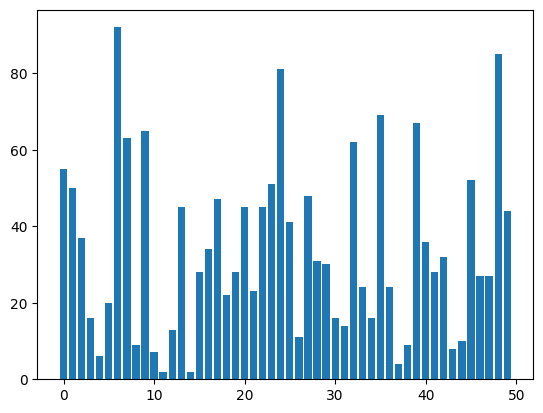

In [32]:
plt.bar(range(50), nb_wrong_pred)
plt.show()

In [33]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=5:
        good_classification.append(i)
    if    nb_wrong_pred[i]>=60:
        bad_classification.append(i)

In [34]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [35]:
for i in good_classification :
    print('Alexnet a bien classifie '+animals[i])

Alexnet a bien classifie mole
Alexnet a bien classifie leopard
Alexnet a bien classifie zebra


In [36]:
for i in bad_classification:
    print('Alexnet a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

Alexnet a mal classifie horse , melange souvent avec cow
Alexnet a mal classifie german+shepherd , melange souvent avec collie
Alexnet a mal classifie siamese+cat , melange souvent avec persian+cat
Alexnet a mal classifie chimpanzee , melange souvent avec gorilla
Alexnet a mal classifie chihuahua , melange souvent avec german+shepherd
Alexnet a mal classifie otter , melange souvent avec beaver
Alexnet a mal classifie deer , melange souvent avec antelope
Alexnet a mal classifie cow , melange souvent avec ox


### Conclusion ###

Alexnet a une très bien performance en classification des animaux. Mais il a même la difficulté à classifer deux animaux similaires.
À faire:
1.Étudier si VIT a une meilleure performance à classifer deux animaux similaire.
2.Essayer de comprendre la logique de la construction de AlexNet